In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model


from fastai.vision.all import *

#!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [2]:

BATCH_SIZE = 8


dataset_path = Path('../input/petfinder-pawpularity-score/')

train_df = pd.read_csv(dataset_path/'train.csv')

train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True)


train_df['norm_score'] = train_df['Pawpularity']/100


In [3]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [4]:
num_bins = int(np.floor(1+np.log2(len(train_df))))

train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)

In [5]:
from sklearn.model_selection import StratifiedKFold, KFold

train_df['fold'] = -1

N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=N_FOLDS,shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

In [6]:
train_df

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
0,0,1,1,1,0,0,0,0,0,0,0,0,31,../input/petfinder-pawpularity-score/train/50ecb023e6d62ea3294649df55f67563.jpg,0.31,4,1
1,0,1,1,1,0,0,0,0,1,1,0,0,72,../input/petfinder-pawpularity-score/train/3edad7cfd93802d47d39332fe7f249e3.jpg,0.72,10,0
2,0,1,1,0,0,0,1,0,0,0,0,0,38,../input/petfinder-pawpularity-score/train/f2884194384b143144250478f914b4f8.jpg,0.38,5,1
3,0,1,1,1,0,0,0,0,0,0,0,0,30,../input/petfinder-pawpularity-score/train/6a28276ae94ee222197a6fa50f0b5899.jpg,0.30,4,0
4,0,1,1,1,0,0,0,0,1,0,0,0,42,../input/petfinder-pawpularity-score/train/e05c7f5d32068ff601d9431e4868487e.jpg,0.42,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,1,1,1,0,0,0,0,0,0,0,0,17,../input/petfinder-pawpularity-score/train/0cf6596378798b26cc0c8dfa40d42eb5.jpg,0.17,2,1
9908,0,1,1,1,0,0,0,0,0,0,1,0,42,../input/petfinder-pawpularity-score/train/2a9bc1087df9c3246667a6f8da897c88.jpg,0.42,5,1
9909,0,0,1,1,0,0,0,0,0,0,0,0,50,../input/petfinder-pawpularity-score/train/5ea699b97942c65f74ca3a6c2c8240c6.jpg,0.50,6,1
9910,0,1,1,1,0,0,0,0,0,0,0,0,26,../input/petfinder-pawpularity-score/train/76eea156482f85e1bf068251427e6b35.jpg,0.26,3,1


In [7]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

def get_data(fold):

    train_df_f = train_df.copy()
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    
    dls = ImageDataLoaders.from_df(train_df_f, 
                               valid_pct=0.2, 
                               valid_col='is_valid', 
                               fn_col='path', 
                               label_col='norm_score', 
                               y_block=RegressionBlock, 
                               bs=BATCH_SIZE, 
                               num_workers=8,
                               item_tfms=Resize(224), 
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()]))
    
    return dls

In [8]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse, cbs=[MixUp(0.2)]).to_fp16()
    
    return learn

In [9]:
test_df = pd.read_csv(dataset_path/'test.csv')


NEED_TRAIN = True

test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [10]:
test_df['Pawpularity']

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
Name: Pawpularity, dtype: int64

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647543,0.643436,17.061827,06:20
1,0.646189,0.644065,17.265142,06:13
2,0.641324,0.640734,16.654465,06:12


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6434364318847656.
Better model found at epoch 2 with valid_loss value: 0.6407344341278076.


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.645758,0.646213,17.262283,06:14
1,0.646624,0.643384,16.920645,06:14
2,0.637821,0.641895,16.775547,06:13


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6462134122848511.
Better model found at epoch 1 with valid_loss value: 0.643383800983429.
Better model found at epoch 2 with valid_loss value: 0.6418952345848083.


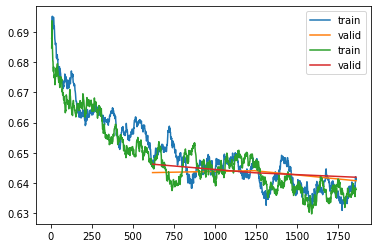

In [12]:
import gc

from sklearn.metrics import mean_squared_error

all_preds = []
    

for i in range(N_FOLDS):

    print(f'Fold {i} results')

    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(),
                                      EarlyStoppingCallback(monitor='petfinder_rmse', 
                                                            comp=np.less, patience=2)]) 


    learn.recorder.plot_loss()

    dls = ImageDataLoaders.from_df(train_df, 
                           valid_pct=0.2,  
                           fn_col='path', 
                           label_col='norm_score', 
                           y_block=RegressionBlock, 
                           bs=BATCH_SIZE, 
                           num_workers=8,
                           item_tfms=Resize(224), 
                           batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()]))



    test_dl = dls.test_dl(test_df)

    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)

    all_preds.append(preds)


    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [13]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)